<div class="alert alert-success">
  <strong>DATASET:</strong> 5j0n_ProjectionsAngles_ProjNber5000_AngCoverage2.0,1.0,0.5_AngShift0.0,0.0,0.0.h5
    <br/>
    <strong>PROJECTION DISTANCE (d_P):</strong> estimated distances (model nosiy_var0_5a1a.h5)
</div>

# Reconstruction

<div class="alert alert-danger">
  <strong>NOTE:</strong> This is done on a PC where I don't need X11 forwarding (since <code>mayavi</code> is a graphic package, and the lab's server doesn't support X11).
</div>

Reference: https://tomroelandts.com/articles/astra-toolbox-tutorial-reconstruction-from-projection-images-part-2

In [8]:
!pip install mayavi

  Using cached mayavi-4.7.2.tar.gz (7.1 MB)
  Created wheel for mayavi: filename=mayavi-4.7.2-cp36-cp36m-linux_x86_64.whl size=19738506 sha256=59f6e866764c9dc20c22cc9537fc71cf922ec8a477ec8982072d03aaaa1480f2
  Stored in directory: /home/jelena/.cache/pip/wheels/33/49/8d/603649120471b576b7d80b34427a44f0968bcae736a3dba98c
Successfully built mayavi


In [2]:
#!pip install mayavi==4.7.0

In [3]:
# !pip install gast

In [98]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [9]:
!python --version

Python 3.6.9 :: Anaconda, Inc.


In [10]:
import numpy as np
from os import mkdir
from os.path import join, isdir
from imageio import imread, imwrite
import matplotlib.pyplot as plt
import astra
import h5py
import os
import mrcfile
#from tvtk.api import tvtk
from mayavi import mlab
from IPython.display import Image
import sys
sys.path.append("../..") 
from cryoem.reconstruction import reconstruct
from cryoem.conversions import quaternion2euler

In [11]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13638700959654978508
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16386587161270811695
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16853904067609592537
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2554855424
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10936266514643469340
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


---

# Reconstruction with Ground-Truth Angles

## Reconstruction

In [64]:
import numpy as np
from os import mkdir
from os.path import join, isdir
from imageio import imread, imwrite
from cryoem.rotation_matrices import RotationMatrix
import astra
import mrcfile
from pathlib import Path

def reconstruct(projections, angles, mrc_filename=None, overwrite=False, vol_shape=None):
    # Generate orientation vectors based on angles
    orientation_vectors   = RotationMatrix(angles)

    # Reshape projections correctly 
    projections1 = np.transpose(projections, (1, 0, 2))
    
    # Get projection dimension
    proj_size = projections1.shape[0]
    if vol_shape is None:
        vol_shape = [proj_size, proj_size, proj_size]

    # Create projection 2D geometry in ASTRA
    proj_geom = astra.create_proj_geom('parallel3d_vec', proj_size, proj_size, orientation_vectors)
    projections_id = astra.data3d.create('-sino', proj_geom, projections1)

    # Create reconstruction.
    vol_geom = astra.creators.create_vol_geom(vol_shape[1], vol_shape[2], vol_shape[0])
    reconstruction_id = astra.data3d.create('-vol', vol_geom, data=0)
    
    alg_cfg = astra.astra_dict('BP3D_CUDA')
    alg_cfg['ProjectionDataId'] = projections_id
    alg_cfg['ReconstructionDataId'] = reconstruction_id
    algorithm_id = astra.algorithm.create(alg_cfg)
    astra.algorithm.run(algorithm_id)
    reconstruction = astra.data3d.get(reconstruction_id)


    # Limit and scale reconstruction.
    reconstruction[reconstruction < 0] = 0
    reconstruction /= np.max(reconstruction)
    reconstruction = np.round(reconstruction * 255).astype(np.uint8)

    # Cleanup.
    astra.algorithm.delete(algorithm_id)
    astra.data3d.delete(reconstruction_id)
    astra.data3d.delete(projections_id)


    # Save reconstruction to mrc file for chimera
    if mrc_filename:
        Path(mrc_filename).parent.mkdir(parents=True, exist_ok=True)
        with mrcfile.new(mrc_filename, overwrite=overwrite) as mrc:
            mrc.set_data(reconstruction)
        
    return reconstruction

def reconstruct_from_file(input_file, limit=3000, mrc_filename=None):
    data = np.load(f'data/{input_file}.npz')
    projections, angles = data["arr_0"].astype(np.float64)[:limit, :, :], data["arr_1"].astype(np.float64)[:limit, :]

    return reconstruct(projections, angles, mrc_filename)


In [73]:
# half coverage (AngCoverage=0.5)
projections_filename = "../../data/robustness_to_unseen_proteins/5j0n_ProjectionsAngles_ProjNber1000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(projections_filename, 'r')

projections = data["Projections"]
angles_true = data["Angles"]

In [74]:
# #projections = np.load("data/5a1a_projections.npy")
# #angles_predicted = np.load("data/5a1a_angles_predicted.npy")
# angles_true = np.load("data/5a1a_angles_true.npy")

In [92]:
reconstruction = reconstruct(projections[:3000], angles_true[:3000], mrc_filename="../../data/robustness_to_unseen_proteins/5j0n_gt.mrc", overwrite=True, vol_shape=[190, 80, 120])
#reconstruction = reconstruct(projections[:3000], angles_true[:3000], mrc_filename="../../data/robustness_to_unseen_proteins/5j0n_gt.mrc", overwrite=True, vol_shape=[80, 80, 80])

In [91]:
mlab.contour3d(reconstruction, transparent=True)
mlab.colorbar(orientation='vertical')
# mlab.savefig("data/5a1a_projections_and_angles.tiff")
mlab.show()

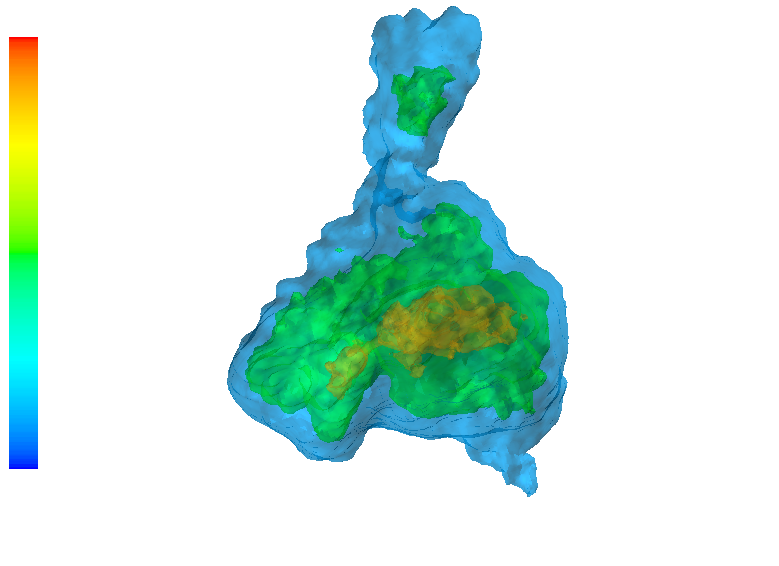

In [18]:
Image(filename='../../data/robustness_to_unseen_proteins/ground_truth_reconstruction_5j0n.png')

---

# Reconstruction after Angle Recovery

## Reconstruction

In [93]:
projections_filename = "../../data/robustness_to_unseen_proteins/5j0n_ProjectionsAngles_ProjNber1000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(projections_filename, 'r')

projections = data["Projections"]

In [96]:
angles_predicted = np.load("../../data/robustness_to_unseen_proteins/angle_recovery__angles_predicted.npy")
reconstruction = reconstruct(projections[:3000], angles_predicted[:3000], mrc_filename="../../data/robustness_to_unseen_proteins/5j0n_ap.mrc", vol_shape=None)

In [97]:
mlab.contour3d(reconstruction, transparent=True)
mlab.colorbar(orientation='vertical')
# mlab.savefig("data/5a1a_projections_and_angles.tiff")
mlab.show()

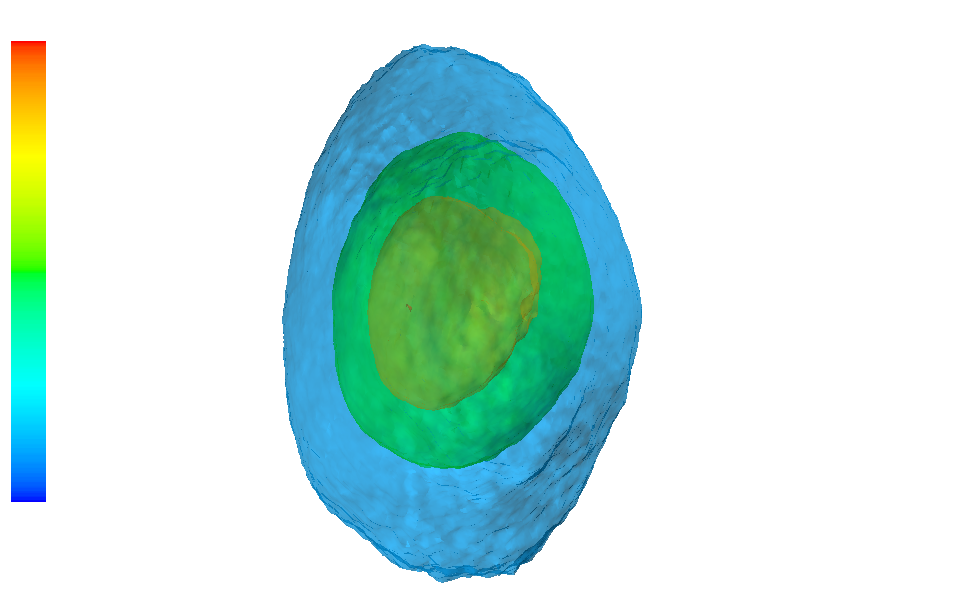

In [22]:
Image(filename='../../data/robustness_to_unseen_proteins/angles_predicted_reconstruction_5j0n.png')

---

# Reconstruction after Angle Alignment

## Reconstruction

In [17]:
#projections = np.load("data/projections.npy")
angles_predicted = np.load("../../data/5a1a_angles_predicted_rotated.npy")
reconstruction = reconstruct(projections[:3000], angles_predicted[:3000], mrc_filename="5a1a_reconstructed.mrc")

In [18]:
mlab.contour3d(reconstruction, transparent=True)
mlab.colorbar(orientation='vertical')
# mlab.savefig("data/5a1a_projections_and_angles.tiff")
mlab.show()

In [99]:
#Image(filename='data/5a1a_estimated_le0.5_50k_aligned.png')

---